# DeepART Dev Notebook

In [1]:
import torch
import torch.nn as nn

import logging
from abc import ABC, abstractmethod
from typing import List, Tuple, Dict, Any
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

In [2]:
# device = torch.device("mps")
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
# model: torch.nn.Module
class LocalUpdate(ABC):

    def __init__(self):
        self.logger = logging.getLogger(
            f"{__name__}-{self.__class__.__name__}"
        )

    @abstractmethod
    def update(
        self,
        x: torch.Tensor,
        w: torch.Tensor,
    ):
        pass

In [ ]:
class Hebb(LocalUpdate):
    """
    Implements a local Hebbian weight update rule:
    Δw_ij = eta * y_i * x_j
    where y_i is the output, x_j is the input, and eta is the learning rate.
    """

    def __init__(self, eta=0.01):
        super().__init__()
        self.eta = eta
        self.previous = []

    def update_model(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
        model: nn.Sequential,
    ):
        ox = x
        activations = []
        for layer in model:
            x = layer(x)
            activations.append(x)

        inputs = [ox] + (activations[:-1])
        n_layers = len(model) - 1
        for ix, layer in enumerate(model):
            if hasattr(layer, "weight"):
                if ix == n_layers:
                    dW = self.wh_update(inputs[ix], activations[ix], layer.weight, y)
                    layer.weight += dW
                else:
                    dW = self.update(inputs[ix], activations[ix], layer.weight)
                    layer.weight += dW

    def wh_update(
        self,
        x: torch.Tensor,  # shape: (batch_size, input_dim)
        y: torch.Tensor,
        w: torch.Tensor,   # shape: (output_dim, input_dim)
        target: torch.tensor
    ):
        # OPTION 1: ZIP
        # d_ws = torch.zeros(x.size(0), *w.shape)
        # for idx, (x_sample, ys, targets) in enumerate(zip(x, y, target)):
        #     d_w = self.eta * torch.outer(targets - ys, x_sample)  # shape: (output_dim, input_dim)
        #     # d_w = 0.1 * torch.outer(targets - ys, x_sample)  # shape: (output_dim, input_dim)
        #     # torch.einsum('bp,bqr->bpqr', v, M) # batch-wise operation v.shape=(b,p) M.shape=(b,q,r)
        #     # torch.einsum('p,qr->pqr', v, M)    # cross-batch operation

        #     d_ws[idx] = d_w
        # OPTION 2: EINSUM
        d_ws = self.eta * torch.einsum('bp,bq->bpq', (target-y), x)

        return torch.mean(d_ws, dim=0)

    def update(
        self,
        x: torch.Tensor,  # shape: (batch_size, input_dim)
        y: torch.Tensor,
        w: torch.Tensor   # shape: (output_dim, input_dim)
    ):
        # OPTION 1: ZIP
        # Allocate weight update for each sample
        # d_ws = torch.zeros(x.size(0), *w.shape).to(device)
        # d_ws = torch.zeros(x.size(0), *w.shape)
        # for idx, (x_sample, ys) in enumerate(zip(x, y)):
        #     # d_w = self.eta * torch.outer(ys, x_sample - ys @ w)  # shape: (output_dim, input_dim)
        #     d_w = self.eta * torch.outer(ys, x_sample - ys @ w)  # shape: (output_dim, input_dim)
        #     d_ws[idx] = d_w

        # OPTION 2: EINSUM
        d_ws = self.eta * torch.einsum('bp,bq->bpq', y, x - y @ w)  # shape: (output_dim, input_dim)

        return torch.mean(d_ws, dim=0)


class SimpleHebbNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        nh = 100
        nh2 = 50
        self.fc = nn.Sequential(
            nn.Linear(input_dim, nh, bias=False),
            nn.Tanh(),
            # nn.Sigmoid(),
            # nn.SiLU(),
            # nn.ReLU6(),

            nn.Linear(nh, nh2, bias=False),
            nn.Tanh(),
            # nn.Sigmoid(),
            # nn.SiLU(),
            # nn.ReLU6(),

            nn.Linear(nh2, output_dim, bias=False),
            # nn.ReLU6(),
        )
        for p in self.fc.parameters():
            p.requires_grad = False

        # self.fc[-1].weight.uniform_()
        return

    def forward(self, x):
        return self.fc(x)

# Prepare MNIST data (flattened)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten
])

In [13]:
# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform,
mnist_train = datasets.USPS(root='./data', train=True, download=True, transform=transform,
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    # target_transform=transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Lambda(lambda y: F.one_hot(y, num_classes=10)),
    # ])
)
# loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
loader = DataLoader(mnist_train, batch_size=1024, shuffle=True)

# Prepare MNIST test data
# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_test = datasets.USPS(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=1024, shuffle=False)

# Instantiate model and Hebbian updater
# input_dim = 28 * 28
input_dim = 16 * 16
output_dim = 10
model = SimpleHebbNet(input_dim, output_dim)
hebb_updater = Hebb(eta=0.05)

# GPU = False
GPU = True

if GPU:
    model = model.to(device)

# model.fc[-1].weight
# a = torch.randn((1, 10))
# b = torch.randn((1, 50))
# c = torch.randn((1, 10))
# d = torch.einsum('bp,bq->bpq', (a-c), b)
# d.shape

mnist_train[1][0].max()
mnist_train[1][0].shape
mnist_train[1][1]


tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [6]:
def test(model, test_loader, toprint=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:

            if GPU:
                data = data.to(device)
                target = target.to(device)

            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    accuracy = correct / total
    if toprint:
        print(f"Test accuracy: {accuracy:.4f}")
    return accuracy

perfs = []
n_epochs = 50
for ie in range(50):
    for data, target in tqdm(loader):
        if GPU:
            data = data.to(device)
            target = target.to(device)
        hebb_updater.update_model(data, target, model.fc)
    perfs.append(test(model, test_loader))


100%|██████████| 8/8 [00:00<00:00, 54.38it/s]


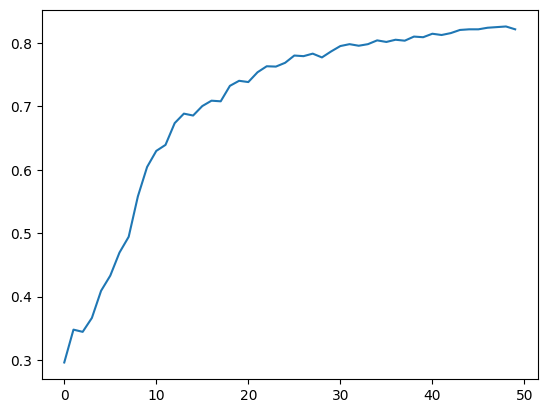

In [7]:
plt.plot(range(n_epochs), perfs)

In [8]:
test(model, test_loader, toprint=True)

Test accuracy: 0.8216


0.8216243148978575

In [9]:
def get_points(model, test_loader):
    model.eval()
    outputs = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            if GPU:
                data = data.to(device)
                target = target.to(device)

            output = model(data)
            outputs.append(output)
            targets.append(target)

    outputs = torch.cat(outputs)
    targets = torch.cat(targets)
    if GPU:
        outputs = outputs.to("cpu")
        targets = targets.to("cpu")
    return outputs, targets

def add_2d_scatter(ax, points, colors, title=None):
    x, y = points.T
    ax.scatter(x, y, s=50, c=colors, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def plot_2d(points, colors, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, colors)
    plt.show()

x, y = get_points(model, test_loader)

In [10]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    max_iter=250,
    random_state=0,
)

x, y = get_points(model, test_loader)

S_t_sne = t_sne.fit_transform(x)

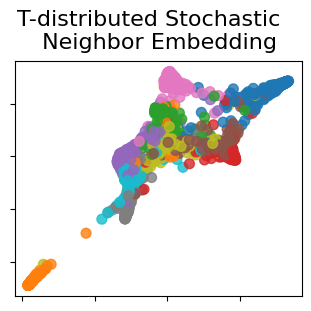

In [11]:
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in y]
plot_2d(S_t_sne, colors, "T-distributed Stochastic  \n Neighbor Embedding")

In [96]:
data, target = next(iter(test_loader))
if GPU:
    data = data.to(device)
    target = target.to(device)

output = model(data)
# output
pred = output.argmax(dim=1)
pred
# output

tensor([4, 6, 3, 4, 6, 0, 0, 0, 6, 9, 6, 2, 3, 4, 0, 3, 1, 2, 9, 6, 2, 2, 4, 4,
        6, 2, 0, 3, 0, 3, 7, 0, 5, 0, 7, 9, 0, 0, 0, 7, 0, 0, 1, 0, 7, 1, 0, 8,
        2, 0, 0, 5, 1, 0, 0, 6, 5, 9, 2, 0, 9, 0, 4, 7, 0, 4, 1, 2, 2, 1, 8, 3,
        7, 2, 0, 9, 0, 1, 2, 1, 2, 0, 7, 2, 0, 6, 7, 2, 2, 0, 9, 0, 1, 8, 2, 0,
        7, 0, 0, 9, 0, 0, 7, 3, 0, 7, 2, 5, 7, 9, 3, 3, 9, 9, 7, 0, 5, 9, 9, 6,
        8, 5, 7, 0, 6, 8, 6, 6], device='mps:0')

In [97]:
output[1]

tensor([ 0.1563,  0.0421,  0.2453, -0.0671,  0.3685, -0.0331,  0.5177, -0.0104,
        -0.1701, -0.0891], device='mps:0')

In [12]:
x, ix = next(iter(loader))
x = x[0]
ox = x
activations = []
if GPU:
    x = x.to(device)
for layer in model.fc:
    x = layer(x)
    activations.append(x)

print(len(activations))
print(activations[0].shape)
ins = [ox] + (activations[:-1])

5
torch.Size([100])
